In [1]:
import pickle
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn import decomposition
import gym

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [15]:
def load_demonstrations(envname="Hopper",n_pos_demos=10,n_neg_demos=100):
    pos_data = np.load("./data/stochastic.trpo."+envname+".0.00.npz")
    
    pos_obs = np.concatenate([pos_data['obs'][idx][:-1] for idx in range(n_pos_demos)])
    pos_next_obs = np.concatenate([pos_data['obs'][idx][1:] for idx in range(n_pos_demos)])
    pos_act = np.concatenate([pos_data['acs'][idx][:-1] for idx in range(n_pos_demos)])
    pos_exp_rets = np.mean([pos_data['ep_rets'][idx] for idx in range(n_pos_demos)])

    demo_file = open('./'+envname+'-v1-negative-demo.pkl', 'rb')
    neg_data = pickle.load(demo_file)[0]
    
    neg_obs = np.concatenate([neg_data[idx]['observes'][:-1] for idx in range(n_neg_demos)])
    neg_next_obs = np.concatenate([neg_data[idx]['observes'][1:] for idx in range(n_neg_demos)])
    neg_act = np.concatenate([neg_data[idx]['actions'][:-1] for idx in range(n_neg_demos)])

    obs = np.concatenate([pos_obs,neg_obs])
    next_obs = np.concatenate([pos_next_obs,neg_next_obs])
    act = np.concatenate([pos_act,neg_act])
    
    return neg_obs, neg_next_obs, neg_act, pos_obs, pos_next_obs, pos_act, obs, next_obs, act

def gauss_normalization(x, mean=None, std=None):
    if mean.any() == None:
        mean = np.mean(x,axis=0)
    if std.any() == None:
        std = np.std(x,axis=0)

    nz_x = (x - mean)/std
    return nz_x

def scale_normalization(x, scale_x=None):
    if scale_x.any() == None:
        scale_x = np.max(np.abs(x),axis=0)
    
    nz_x = x/scale_x
    return nz_x

def noramlize_demonsrations(neg_obs, neg_next_obs, neg_act, pos_obs, pos_next_obs, pos_act, obs, next_obs, act):

    obs_mean = np.mean(obs,axis=0)
    obs_std = np.std(obs,axis=0)
    next_obs_mean = np.mean(next_obs,axis=0)
    next_obs_std = np.mean(next_obs,axis=0)
    act_scale = np.mean(np.abs(act),axis=0)

    nz_obs = gauss_normalization(obs,obs_mean,obs_std)
    nz_next_obs = gauss_normalization(next_obs,next_obs_mean,next_obs_std)
    nz_act = scale_normalization(act,act_scale)

    nz_pos_obs = gauss_normalization(pos_obs,obs_mean,obs_std)
    nz_pos_next_obs = gauss_normalization(pos_next_obs,next_obs_mean,next_obs_std)
    nz_pos_act = scale_normalization(pos_act,act_scale)
    
    nz_neg_obs = gauss_normalization(neg_obs,obs_mean,obs_std)
    nz_neg_next_obs = gauss_normalization(neg_next_obs,next_obs_mean,next_obs_std)
    nz_neg_act = scale_normalization(neg_act,act_scale)

    return nz_neg_obs, nz_neg_next_obs, nz_neg_act, nz_pos_obs, nz_pos_next_obs, nz_pos_act, nz_obs, nz_next_obs, nz_act

if __name__ == "__main__":

    # envname = "HalfCheetah"
    envname = "Hopper"
    # envname = "Walker2d"

    n_pos_demos = 50
    n_neg_demos = 1000
    
    neg_obs, neg_next_obs, neg_act, pos_obs, pos_next_obs, pos_act, obs, next_obs, act = load_demonstrations(envname,n_pos_demos=n_pos_demos,n_neg_demos=n_neg_demos)
    nz_neg_obs, nz_neg_next_obs, nz_neg_act, nz_pos_obs, nz_pos_next_obs, nz_pos_act, nz_obs, nz_next_obs, nz_act = noramlize_demonsrations(neg_obs, neg_next_obs, neg_act, pos_obs, pos_next_obs, pos_act, obs, next_obs, act)
    
    obs_mean = np.mean(obs,axis=0)
    obs_std = np.std(obs,axis=0)
    next_obs_mean = np.mean(next_obs,axis=0)
    next_obs_std = np.mean(next_obs,axis=0)
    act_scale = np.mean(np.abs(act),axis=0)
    
    env = gym.make(envname+"-v1")
    env.seed(seed=0)

    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]
    
    print("{:d} positive demonstrations are loaded".format(n_pos_demos))
    print("Observation shape : {}".format(pos_obs.shape))
    print("Action shape : {}".format(pos_act.shape))
    print("Next observation shape : {}".format(pos_next_obs.shape))
    print("")
    
    print("{:d} negative demonstrations are loaded".format(n_neg_demos))
    print("Observation shape : {}".format(neg_obs.shape))
    print("Action shape : {}".format(neg_act.shape))
    print("Next observation shape : {}".format(neg_next_obs.shape))
    print("")


[2018-07-12 22:03:09,833] Making new env: Hopper-v1


50 positive demonstrations are loaded
Observation shape : (31337, 11)
Action shape : (31337, 3)
Next observation shape : (31337, 11)

1000 negative demonstrations are loaded
Observation shape : (8967, 11)
Action shape : (8967, 3)
Next observation shape : (8967, 11)



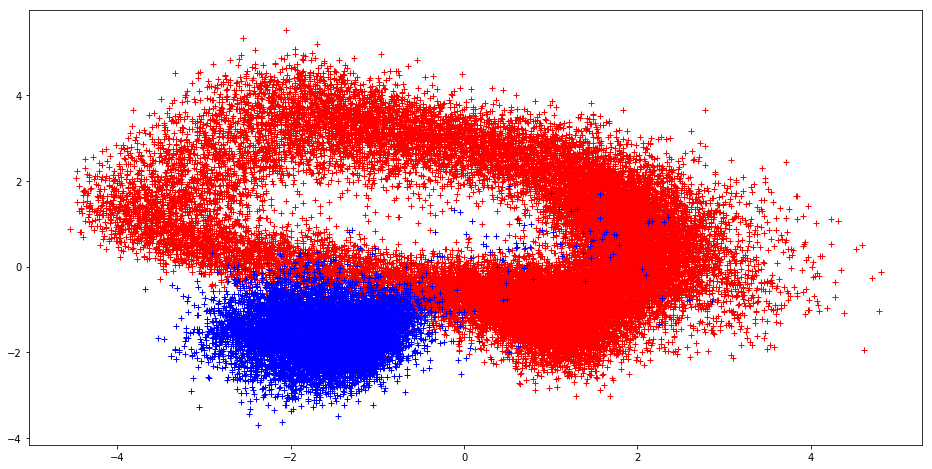

In [11]:
pca = decomposition.PCA(n_components=2)
pca.fit(nz_obs)
pos_demo_pca = pca.transform(nz_pos_obs)
neg_demo_pca = pca.transform(nz_neg_obs)

fig = plt.figure(figsize=(16, 8))
plt.plot(pos_demo_pca[:,0],pos_demo_pca[:,1],'r+')
plt.plot(neg_demo_pca[:,0],neg_demo_pca[:,1],'b+')
plt.show()

# fig = plt.figure(figsize=(16, 8))
# ax = fig.add_subplot(121, projection='3d')
# ax.view_init(90, 60)
# plt.plot(observes_demo_pca[:,0],observes_demo_pca[:,1],observes_demo_pca[:,2],marker='+',c='b')
# ax = fig.add_subplot(122, projection='3d')
# ax.view_init(30, 30)
# plt.plot(observes_demo_pca[:,0],observes_demo_pca[:,1],observes_demo_pca[:,2],marker='+',c='b')
# plt.show()

In [39]:
class LatentDynamics():
    def __init__(self, act_dim, hdim = 128, ldim = 4, epochs = 10000, lr = 1e-5, seed=0):
        self.act_dim = act_dim
        
        self.seed = seed
        self.epochs = epochs
        
        self.lr = lr
        self.hdim = hdim
        self.ldim = ldim
        
        self.std = 1e-1
        
        self._build_graph()
        self._init_session()

    def _build_graph(self):
        self.g = tf.Graph()
        with self.g.as_default():
            self._placeholders()
            self._ldm_nn()
            self._loss_train_op()
            self.init = tf.global_variables_initializer()
            
    def _placeholders(self):
        # observations, actions and advantages:
        self.next_latent_ph = tf.placeholder(tf.float32, (None, self.ldim), 'next_latent')
        self.latent_ph = tf.placeholder(tf.float32, (None, self.ldim), 'latent')
        self.act_ph = tf.placeholder(tf.float32, (None, self.act_dim), 'act')

        # learning rate:
        self.lr_ph = tf.placeholder(tf.float32, (), 'lr')

    def _ldm_nn(self):
        self.passive_dynamics, self.control_dynamics, self.control_std = self._dynamics(self.latent_ph)
        self.next_latent_predict = self.latent_ph + self.passive_dynamics + tf.reduce_sum(self.control_dynamics*tf.tile(self.act_ph[:,tf.newaxis,:],[1,self.ldim,1]))
        self.next_latent = self.next_latent_predict + self.control_std*tf.random_normal(tf.shape(self.next_latent_predict),seed=self.seed)
        
    def _dynamics(self,latent,reuse=False):
        hid1_size = self.hdim
        latent_size = self.ldim
        
        with tf.variable_scope("control_dynamics"):
            # Control Dynamics
            out = tf.layers.dense(latent, hid1_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h1",
                                  reuse=reuse)
            out = tf.layers.dense(out, hid1_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h2",
                                  reuse=reuse)
            passive_dynamics = tf.layers.dense(out, latent_size,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="passive_dynamics",
                                  reuse=reuse)
            control_std_logits = tf.layers.dense(out, latent_size,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="std_dynamics",
                                  reuse=reuse)
            control_std = self.std*tf.sigmoid(control_std_logits) + 1e-6
            control_dynamics_flatten = tf.layers.dense(out, latent_size*self.act_dim,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="flatten_dynamics",
                                  reuse=reuse)
            control_dynamics = tf.reshape(control_dynamics_flatten,[-1,latent_size,self.act_dim], name="control_dynamics")
            
        return passive_dynamics, control_dynamics, control_std

            
    def _loss_train_op(self):
        # Define Loss
        latent_prediction_loss = tf.reduce_sum(tf.log(self.control_std) + 0.5*tf.square((self.next_latent_predict - self.next_latent_ph)/self.control_std),axis=1)
        self.dyn_loss = tf.reduce_mean(latent_prediction_loss)
        
        l2loss = 0.5*tf.reduce_sum(tf.square(self.next_latent_predict - self.next_latent_ph),axis=1)
        self.l2loss = tf.reduce_mean(l2loss)
        
        # OPTIMIZER 
        optimizer = tf.train.AdamOptimizer(self.lr_ph)
        self.train_op = optimizer.minimize(self.dyn_loss)
    
    def _init_session(self):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config,graph=self.g)
        self.sess.run(self.init)
   
    def get_prediction(self,latent):
        next_latent = self.sess.run(self.next_latent,feed_dict={self.latent_ph:latent})
        return next_latent
    
    def get_control_dynamics(self,latent):
        return self.sess.run(self.control_dynamics,feed_dict={self.latent_ph:latent})
            
    def train(self,latent,act,next_latent,batch_size = 1024): # TRAIN POLICY
        
        num_batches = max(latent.shape[0] // batch_size, 1)
        batch_size = latent.shape[0] // num_batches
        
        for e in range(self.epochs+1):
            latent,act,next_latent = shuffle(latent,act,next_latent,random_state=0)
            for j in range(num_batches):
                start = j * batch_size
                end = (j + 1) * batch_size
                feed_dict = {self.latent_ph: latent[start:end,:],
                     self.act_ph: act[start:end,:],
                     self.next_latent_ph: next_latent[start:end,:],
                     self.lr_ph: self.lr}        
                self.sess.run(self.train_op, feed_dict)
            
            if e < self.epochs/3:
                self.lr = 1e-4
            elif e < 2*self.epochs/3:
                self.lr = 5e-5
            else:
                self.lr = 1e-5
                
#             if (e%500)==0:
#                 feed_dict = {self.latent_ph: latent,
#                      self.act_ph: act,
#                      self.next_latent_ph: next_latent,
#                      self.lr_ph: self.lr}        
#                 dyn_loss, l2loss = self.sess.run([self.dyn_loss, self.l2loss], feed_dict)
#                 print('[{:05d}/{:05d}] Latent Prediction : {:.05f}, L2 Loss : {:.05f}'.
#                       format(e, self.epochs, dyn_loss, l2loss))
        return dyn_loss
    
if __name__=="__main__":
    ldm = LatentDynamics(act_dim,hdim=128,ldim=obs_dim,epochs = 30000)
    ldm.train(nz_obs,nz_act,nz_next_obs)

KeyboardInterrupt: 

In [40]:
class Value(object):
    def __init__(self, obs_dim, act_dim, hdim = 64, ldim = 4, epochs = 10000, lr = 1e-3, reg_coeff=1e-1, neg_coeff=1.0, seed=0):
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.seed = seed
        self.epochs = epochs
        self.lr = lr
        self.hdim = hdim
        self.ldim = ldim
        self.reg_coeff = reg_coeff
        self.neg_coeff = neg_coeff
        
        self._build_graph()
        self._init_session()

    def _build_graph(self):
        self.g = tf.Graph()
        with self.g.as_default():
            self._placeholders()
            self._policy_nn()
            self.variables = tf.global_variables()
            self._loss_train_op()
            self.init = tf.global_variables_initializer()
            
    def _placeholders(self):
        # observations, actions and advantages:
        self.pos_latent_ph = tf.placeholder(tf.float32, (None, self.ldim), 'pos_latent')
        self.pos_control_dynamics_ph = tf.placeholder(tf.float32, (None, self.ldim, self.act_dim), 'pos_control_dynamics')
        self.pos_control_ph = tf.placeholder(tf.float32, (None, self.act_dim), 'pos_control')
        self.neg_latent_ph = tf.placeholder(tf.float32, (None, self.ldim), 'neg_latent')
        self.neg_control_dynamics_ph = tf.placeholder(tf.float32, (None, self.ldim, self.act_dim), 'neg_control_dynamics')
        self.neg_control_ph = tf.placeholder(tf.float32, (None, self.act_dim), 'neg_control')

        # learning rate:
        self.lr_ph = tf.placeholder(tf.float32, (), 'lr')

    def _policy_nn(self):
        self.pos_value  = self._value_nn(self.pos_latent_ph)
        value_gradients = tf.gradients(self.pos_value,self.pos_latent_ph,name="pos_value_grads")[0]
        self.pos_control = - tf.reduce_sum(tf.tile(value_gradients[:,:,tf.newaxis],[1,1,self.act_dim])*self.pos_control_dynamics_ph,axis=1)
        
        self.neg_value = self._value_nn(self.neg_latent_ph, reuse=True)
        value_gradients = tf.gradients(self.neg_value,self.neg_latent_ph,name="neg_value_grads")[0]
        self.neg_control = - tf.reduce_sum(tf.tile(value_gradients[:,:,tf.newaxis],[1,1,self.act_dim])*self.neg_control_dynamics_ph,axis=1)
        
    def _value_nn(self, latent_ph, reuse=False):
        hid1_size = self.hdim
        hid2_size = self.hdim
        latent_size = self.ldim
        
        with tf.variable_scope("value_network"):
            # Encoder
            out = tf.layers.dense(latent_ph, hid1_size, tf.tanh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h1",
                                  reuse=reuse)
            out = tf.layers.dense(out, hid2_size, tf.cosh,
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h2",
                                  reuse=reuse)
            value = tf.layers.dense(out, 1,
                                    kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed),
                                    name="value",
                                    reuse=reuse)
        return value

    def _loss_train_op(self):
        pos_loss = tf.reduce_sum(tf.square(self.pos_control_ph - self.pos_control))
        self.pos_loss = tf.reduce_mean(pos_loss)
        
        neg_loss = tf.reduce_sum(tf.maximum(1e-1-tf.square(self.neg_control_ph - self.neg_control),0))
        self.neg_loss = tf.reduce_mean(neg_loss)
        
#         weight_decay = tf.reduce_sum([tf.reduce_sum(tf.reduce_sum(tf.square(var))) for var in self.variables])
        reg = tf.reduce_mean(tf.square(self.pos_value)) + tf.reduce_mean(tf.square(self.neg_value))
        
        self.loss = self.pos_loss + self.neg_coeff*self.neg_loss + self.reg_coeff*reg #+ 1e-4*weight_decay
        
        # OPTIMIZER 
        optimizer = tf.train.AdamOptimizer(self.lr_ph)
        self.train_op = optimizer.minimize(self.loss)
    
    def _init_session(self):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config,graph=self.g)
        self.sess.run(self.init)
    
    def get_control(self,latent,control_dynamics):
        ctrl, val = self.sess.run([self.pos_control, self.pos_value],feed_dict={self.pos_latent_ph:latent,self.pos_control_dynamics_ph:control_dynamics})
        return ctrl, val
    
    def train(self,pos_latent,pos_control_dynamics,pos_control,neg_latent,neg_control_dynamics,neg_control,batch_size = 1024): # TRAIN POLICY
        
        pos_num_batches = max(pos_latent.shape[0] // batch_size, 1)
        neg_num_batches = max(neg_latent.shape[0] // batch_size, 1)
        pos_batch_size = pos_latent.shape[0] // pos_num_batches
        neg_batch_size = neg_latent.shape[0] // neg_num_batches
        num_batches = min(pos_num_batches,neg_num_batches)
        for e in range(self.epochs+1):
            pos_latent,pos_control_dynamics,pos_control= shuffle(pos_latent,pos_control_dynamics,pos_control,random_state=0)
            neg_latent,neg_control_dynamics,neg_control= shuffle(neg_latent,neg_control_dynamics,neg_control,random_state=0)
            for j in range(num_batches):
                pos_start = j * pos_batch_size
                pos_end = (j + 1) * pos_batch_size
                neg_start = j * neg_batch_size
                neg_end = (j + 1) * neg_batch_size
                feed_dict = {self.pos_latent_ph: pos_latent[pos_start:pos_end,:],
                     self.pos_control_dynamics_ph: pos_control_dynamics[pos_start:pos_end,:,:],
                     self.pos_control_ph: pos_control[pos_start:pos_end,:],
                     self.neg_latent_ph: neg_latent[neg_start:neg_end,:],
                     self.neg_control_dynamics_ph: neg_control_dynamics[neg_start:neg_end,:,:],
                     self.neg_control_ph: neg_control[neg_start:neg_end,:],
                     self.lr_ph: self.lr}        
                self.sess.run(self.train_op, feed_dict)
            
            if e < self.epochs/3:
                self.lr = 1e-3
            elif e < 2*self.epochs/3:
                self.lr = 5e-4
            else:
                self.lr = 1e-4
                
#             if (e%500)==0:
#                 feed_dict = {self.pos_latent_ph: pos_latent,
#                      self.pos_control_dynamics_ph: pos_control_dynamics,
#                      self.pos_control_ph: pos_control,
#                      self.neg_latent_ph: neg_latent,
#                      self.neg_control_dynamics_ph: neg_control_dynamics,
#                      self.neg_control_ph: neg_control,
#                      self.lr_ph: self.lr}        
#                 loss, pos_loss, neg_loss = self.sess.run([self.loss, self.pos_loss, self.neg_loss], feed_dict)
#                 print('[{}/{}] Loss : {:.06f}, Pos : {:.06f}, Neg : {:.06f}'.
#                       format(e, self.epochs, loss, pos_loss, neg_loss))
        return loss

if __name__ == "__main__":
    value = Value(obs_dim,act_dim,hdim=128,ldim=obs_dim,epochs = 30000)

    pos_control_dynamics = ldm.get_control_dynamics(nz_pos_obs)
    neg_control_dynamics = ldm.get_control_dynamics(nz_neg_obs)

    value.train(nz_pos_obs,pos_control_dynamics,nz_pos_act,nz_neg_obs,neg_control_dynamics,nz_neg_act)

KeyboardInterrupt: 

In [38]:
def run_episode(env, ldm, value, obs_mean, obs_std, act_scale):
    obs = env.reset()
    observes, actions, rewards, infos = [], [], [], []
    done = False
    while not done:
        obs = obs.astype(np.float32).reshape((1, -1))
        observes.append(obs)

        nz_observation = (obs - obs_mean)/obs_std
        control_dynamic = ldm.get_control_dynamics(nz_observation)
        nz_action, val = value.get_control(nz_observation,control_dynamic)
        action = nz_action*act_scale
        
        actions.append(action)
        obs, reward, done, info = env.step(action)
        if not isinstance(reward, float):
            reward = np.asscalar(reward)
        rewards.append(reward)
        infos.append(info)
        
    return (np.concatenate(observes), np.concatenate(actions),
            np.array(rewards, dtype=np.float32), infos)

def run_policy(env, ldm, value, obs_mean, obs_std, act_scale, episodes):
    total_steps = 0
    trajectories = []
    for e in range(episodes):
        observes, actions, rewards, infos = run_episode(env, ldm, value, obs_mean, obs_std, act_scale)
        total_steps += observes.shape[0]
        trajectory = {'observes': observes,
                      'actions': actions,
                      'rewards': rewards,
                      'infos': infos}
        trajectories.append(trajectory)
    return trajectories

if __name__=="__main__":
    trajectories = run_policy(env, ldm, value, obs_mean, obs_std, act_scale, episodes=100)
    returns_list = [np.sum(t['rewards']) for t in trajectories]
    avg_returns = np.mean(returns_list)
    std_returns = np.std(returns_list)
    print("{}".format(avg_returns))
    print("{}".format(std_returns))

3541.64501953125
352.17730712890625


In [ ]:
def iocfnd(envname="Hopper",n_pos_demos = 50,n_neg_demos = 1000,ldm_hdim=128,ldm_epochs=30000.val_hdim=128,val_epochs=30000,seed=0):
    
    neg_obs, neg_next_obs, neg_act, pos_obs, pos_next_obs, pos_act, obs, next_obs, act = load_demonstrations(envname,n_pos_demos=n_pos_demos,n_neg_demos=n_neg_demos)
    nz_neg_obs, nz_neg_next_obs, nz_neg_act, nz_pos_obs, nz_pos_next_obs, nz_pos_act, nz_obs, nz_next_obs, nz_act = noramlize_demonsrations(neg_obs, neg_next_obs, neg_act, pos_obs, pos_next_obs, pos_act, obs, next_obs, act)
    
    obs_mean = np.mean(obs,axis=0)
    obs_std = np.std(obs,axis=0)
    next_obs_mean = np.mean(next_obs,axis=0)
    next_obs_std = np.mean(next_obs,axis=0)
    act_scale = np.mean(np.abs(act),axis=0)
    
    env = gym.make(envname+"-v1")
    env.seed(seed=seed)

    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]
    
    ldm = LatentDynamics(act_dim,hdim=ldm_hdim,ldim=obs_dim,epochs=ldm_epochs)
    ldm.train(nz_obs,nz_act,nz_next_obs)
    
    value = Value(obs_dim,act_dim,hdim=val_hdim,ldim=obs_dim,epochs=val_epochs)
    pos_control_dynamics = ldm.get_control_dynamics(nz_pos_obs)
    neg_control_dynamics = ldm.get_control_dynamics(nz_neg_obs)
    value.train(nz_pos_obs,pos_control_dynamics,nz_pos_act,nz_neg_obs,neg_control_dynamics,nz_neg_act)
    
    trajectories = run_policy(env, ldm, value, obs_mean, obs_std, act_scale, episodes=100)
    returns_list = [np.sum(t['rewards']) for t in trajectories]
    
    saver_prefix = saver_prefix="./results/seed:{},entcoeff:{:.2e},weight:{},mixture:{:d},epi_size:{}".format(seed,kl_targ,entcoeff,mdn_weight,n_mixture,episode_size)
    f = open( saver_prefix+".pickle", "wb" )
    pickle.dump( evaluation_results, f )
    